In [1]:
pip install imblearn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE, ADASYN
import warnings
warnings.filterwarnings("ignore")
# === 1. Load data ===

df = pd.read_excel("Data_Set_(A+B).xlsx")
df_test = pd.read_excel("Data_Set_C.xlsx")


df['Type'] = df['Type'].apply(lambda x: 1 if x == 2 else 0)
df_test['Type'] = df_test['Type'].apply(lambda x: 1 if x == 2 else 0)

In [77]:
def calculate_v2_features(df):
    # Extract original V1 variables
    N1 = df['N1'].values
    N2 = df['N2'].values
    N3 = df['N3'].values
    I1 = df['I1'].values
    I2 = df['I2'].values
    I3 = df['I3'].values
    gx = df['gx'].values
    gy = df['gy'].values
    gz = df['gz'].values
    
    # Robot geometric parameters (need to be adjusted according to the actual robot configuration)
    L = 0.2  # Robot wheelbase (meters)
    r = 0.05  # Wheel radius (meters)
    alpha = 2 * np.pi / 3  # Angle between adjacent motors (120 degrees)
    
    # Calculate motor angular velocities (radians/second)
    omega1 = (2 * np.pi * N1) / 60
    omega2 = (2 * np.pi * N2) / 60
    omega3 = (2 * np.pi * N3) / 60
    
    # Calculate the robot's linear and angular velocities in the body frame
    Vx_b = (2/3) * r * (omega1 + omega2 * np.cos(alpha) + omega3 * np.cos(alpha))
    Vy_b = (2/3) * r * (omega2 * np.sin(alpha) - omega3 * np.sin(alpha))
    Omega = (r / (3 * L)) * (omega1 + omega2 + omega3)
    
    # Calculate linear velocities in the global frame (assuming the robot's orientation is aligned with the x-axis)
    theta = np.arctan2(gy, gx)  # Estimate orientation using gyroscope data
    Vx = Vx_b * np.cos(theta) - Vy_b * np.sin(theta)
    Vy = Vx_b * np.sin(theta) + Vy_b * np.cos(theta)
    
    # Calculate current components
    Ix = (2/3) * (I1 + I2 * np.cos(alpha) + I3 * np.cos(alpha))
    Iy = (2/3) * (I2 * np.sin(alpha) - I3 * np.sin(alpha))
    I_phi = (1 / (3 * L)) * (I1 + I2 + I3)
    I_sigma = I1 + I2 + I3
    
    # Create V2 feature DataFrame
    v2_features = pd.DataFrame({
        'Vx': Vx,
        'Vy': Vy,
        'Omega': Omega,
        'Ix': Ix,
        'Iy': Iy,
        'I_phi': I_phi,
        'I_sigma': I_sigma
    })
    
    return v2_features

# Calculate V2 features for the training and test sets
X_v2 = calculate_v2_features(df)
X_test_v2 = calculate_v2_features(df_test)

# Target variable
Y = df['Type']
Y_test = df_test['Type']

# === New: Training data sorted by Type ===
# Merge features and labels, sort by 'Type'
train_data = X_v2.copy()
train_data['Type'] = Y.values  # Add the label column

# Sort by 'Type' in ascending order
train_data_sorted = train_data.sort_values(by='Type').reset_index(drop=True)

# Separate the sorted X and Y
X_sorted = train_data_sorted.drop(columns='Type')
Y_sorted = train_data_sorted['Type']

In [78]:
# === 3. Customizable layer structure training function ===
def train_mlp(X, Y, hidden_layers=(50,), activation='relu', solver='adam', max_iter=300, cv=3):
    print(f"Using hidden layer structure: {hidden_layers}")
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layers, activation=activation,
                        solver=solver, max_iter=max_iter, random_state=42)
    # Calculate cross-validation evaluation metrics
    accuracy_scores = cross_val_score(mlp, X, Y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(mlp, X, Y, cv=cv, scoring='f1_macro')
    precision_scores = cross_val_score(mlp, X, Y, cv=cv, scoring='precision_macro')
    recall_scores = cross_val_score(mlp, X, Y, cv=cv, scoring='recall_macro')

    print(f"Cross-validation accuracy: {accuracy_scores.mean():.4f} (Standard deviation: {accuracy_scores.std():.4f})")
    print(f"Cross-validation F1 score: {f1_scores.mean():.4f} (Standard deviation: {f1_scores.std():.4f})")
    print(f"Cross-validation precision: {precision_scores.mean():.4f} (Standard deviation: {precision_scores.std():.4f})")
    print(f"Cross-validation recall: {recall_scores.mean():.4f} (Standard deviation: {recall_scores.std():.4f})")

    return mlp.fit(X, Y)



# Training on original data
Using hidden layer structure: (128, 64, 32)
Cross-validation accuracy: 0.7726 (Standard deviation: 0.0231)
Cross-validation F1 score: 0.4357 (Standard deviation: 0.0074)
Cross-validation precision: 0.3953 (Standard deviation: 0.0032)
Cross-validation recall: 0.4856 (Standard deviation: 0.0136)


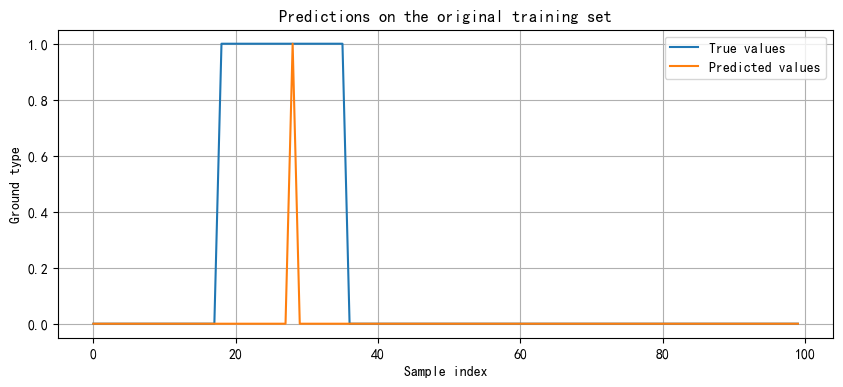

Cross-validation F1 score: 0.4357
Cross-validation accuracy score: 0.7726
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       140
           1       1.00      0.03      0.05        36

    accuracy                           0.80       176
   macro avg       0.90      0.51      0.47       176
weighted avg       0.84      0.80      0.72       176



In [80]:
# === Plotting function ===
def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 4))
    plt.plot(y_true[:100], label='True values')
    plt.plot(y_pred[:100], label='Predicted values')
    plt.title(title)
    plt.xlabel("Sample index")
    plt.ylabel("Ground type")
    plt.legend()
    plt.grid(True)
    plt.show()

# === 4. Training on original data ===
print("# Training on original data")
model_raw = train_mlp(X, Y, hidden_layers=( 128,64,32), activation='tanh', solver='adam', max_iter=300)
pred_raw = model_raw.predict(X)
plot_results(Y.values, pred_raw, "Predictions on the original training set")
print("Cross-validation F1 score: {:.4f}".format(cross_val_score(model_raw, X, Y, cv=3, scoring='f1_macro').mean()))
print("Cross-validation accuracy score: {:.4f}".format(cross_val_score(model_raw, X, Y, cv=3, scoring='accuracy').mean()))
print(classification_report(Y, pred_raw))


# Training on sorted data
Using hidden layer structure: (128, 64, 32)
Cross-validation accuracy: 0.8641 (Standard deviation: 0.0630)
Cross-validation F1 score: 0.7906 (Standard deviation: 0.1013)
Cross-validation precision: 0.8061 (Standard deviation: 0.1214)
Cross-validation recall: 0.7908 (Standard deviation: 0.0968)


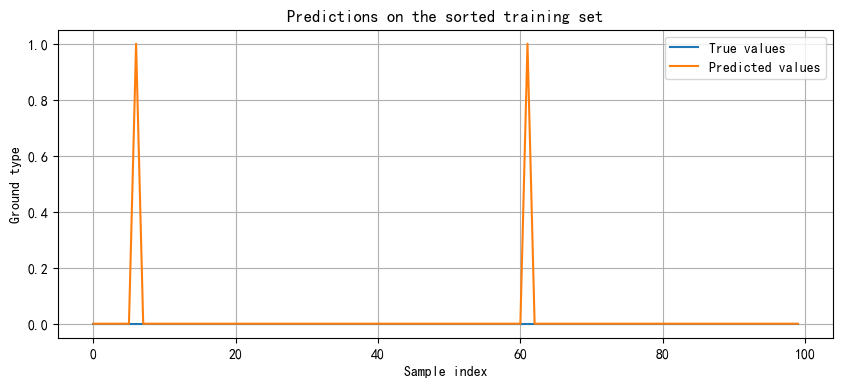

Cross-validation F1 score: 0.4357
Cross-validation accuracy score: 0.7726
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       140
           1       1.00      0.03      0.05        36

    accuracy                           0.80       176
   macro avg       0.90      0.51      0.47       176
weighted avg       0.84      0.80      0.72       176



In [81]:
# === 5. Training on sorted data ===
print("# Training on sorted data")
model_sorted = train_mlp(X_sorted, Y_sorted, hidden_layers=(128, 64, 32), activation='tanh', solver='adam', max_iter=300)
pred_sorted = model_sorted.predict(X_sorted)
plot_results(Y_sorted.values, pred_sorted, "Predictions on the sorted training set")
print("Cross-validation F1 score: {:.4f}".format(cross_val_score(model_raw, X, Y, cv=3, scoring='f1_macro').mean()))
print("Cross-validation accuracy score: {:.4f}".format(cross_val_score(model_raw, X, Y, cv=3, scoring='accuracy').mean()))
print(classification_report(Y, pred_raw))

# Training on normalized data
Using hidden layer structure: (128, 64, 32)
Cross-validation accuracy: 0.9200 (Standard deviation: 0.0536)
Cross-validation F1 score: 0.8895 (Standard deviation: 0.0631)
Cross-validation precision: 0.8860 (Standard deviation: 0.0775)
Cross-validation recall: 0.9084 (Standard deviation: 0.0312)


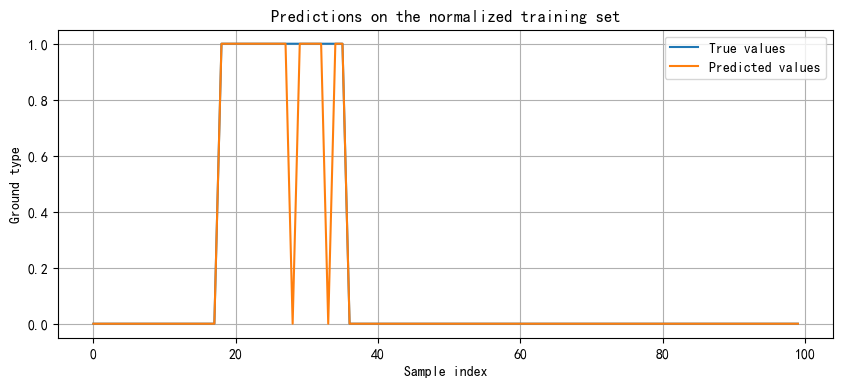

Cross-validation F1 score: 0.4357
Cross-validation accuracy score: 0.7726
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       140
           1       1.00      0.03      0.05        36

    accuracy                           0.80       176
   macro avg       0.90      0.51      0.47       176
weighted avg       0.84      0.80      0.72       176



In [83]:
# === 6. Training on normalized data ===
print("# Training on normalized data")
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
model_norm = train_mlp(X_norm, Y, hidden_layers=(128, 64, 32), activation='tanh', solver='adam', max_iter=300)
pred_norm = model_norm.predict(X_norm)
plot_results(Y.values, pred_norm, "Predictions on the normalized training set")
print("Cross-validation F1 score: {:.4f}".format(cross_val_score(model_raw, X, Y, cv=3, scoring='f1_macro').mean()))
print("Cross-validation accuracy score: {:.4f}".format(cross_val_score(model_raw, X, Y, cv=3, scoring='accuracy').mean()))
print(classification_report(Y, pred_raw))

# Training with SMOTE balancing
Using hidden layer structure: (128, 64, 32)
Cross-validation accuracy: 0.9536 (Standard deviation: 0.0221)
Cross-validation F1 score: 0.9534 (Standard deviation: 0.0224)
Cross-validation precision: 0.9573 (Standard deviation: 0.0180)
Cross-validation recall: 0.9534 (Standard deviation: 0.0226)


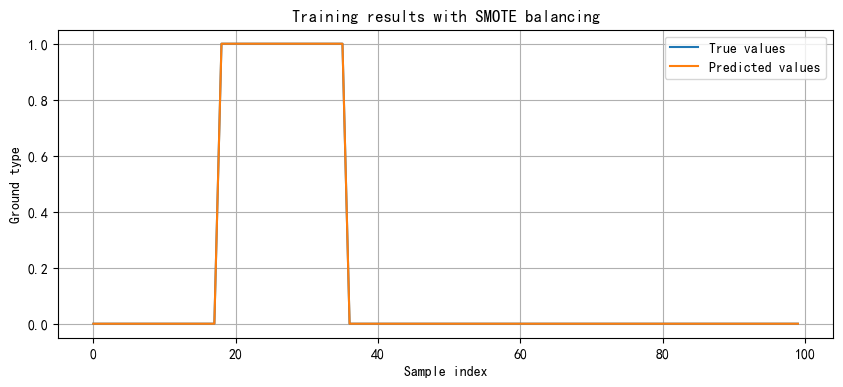

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       140
           1       1.00      0.03      0.05        36

    accuracy                           0.80       176
   macro avg       0.90      0.51      0.47       176
weighted avg       0.84      0.80      0.72       176



In [84]:
# === 7. Training with SMOTE balancing ===
print("# Training with SMOTE balancing")
smote = SMOTE(random_state=42, k_neighbors=1)
X_bal, Y_bal = smote.fit_resample(X_norm, Y)
model_bal = train_mlp(X_bal, Y_bal, hidden_layers=(128, 64, 32), activation='relu', solver='adam', max_iter=300)
pred_bal = model_bal.predict(X_bal)
plot_results(Y_bal, pred_bal, "Training results with SMOTE balancing")

print(classification_report(Y, pred_raw))

# Training with TomekLinks balancing
Using hidden layer structure: (128, 64, 32)
Cross-validation accuracy: 0.9226 (Standard deviation: 0.0367)
Cross-validation F1 score: 0.8851 (Standard deviation: 0.0449)
Cross-validation precision: 0.8753 (Standard deviation: 0.0574)
Cross-validation recall: 0.9046 (Standard deviation: 0.0244)


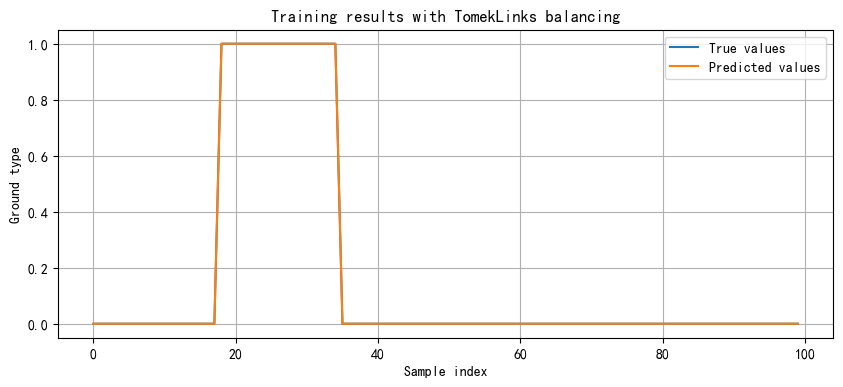

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00        32

    accuracy                           1.00       168
   macro avg       1.00      1.00      1.00       168
weighted avg       1.00      1.00      1.00       168



In [88]:
from imblearn.under_sampling import TomekLinks
print("# Training with TomekLinks balancing")
tomek = TomekLinks(sampling_strategy='all')  # 'all' means clean the boundary samples of all classes
X_tl, Y_tl = tomek.fit_resample(X_norm, Y)

model_tl = train_mlp(X_tl, Y_tl,
                     hidden_layers=(128, 64, 32),
                     activation='relu',
                     solver='adam',
                    max_iter=300)

pred_tl = model_tl.predict(X_tl)

plot_results(Y_tl, pred_tl, "Training results with TomekLinks balancing")
print(classification_report(Y_tl, pred_tl))

# Validation on test set C


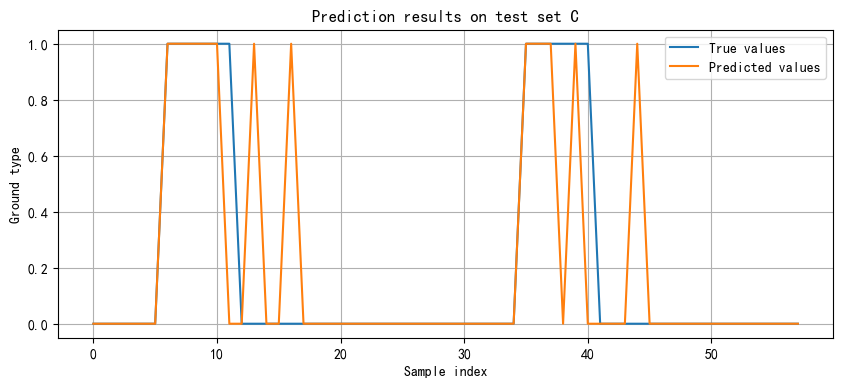

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        46
           1       0.75      0.75      0.75        12

    accuracy                           0.90        58
   macro avg       0.84      0.84      0.84        58
weighted avg       0.90      0.90      0.90        58



In [89]:
# === 8. Validate model generalization on test set C ===
print("# Validation on test set C")
X_test_norm = scaler.transform(X_test)
pred_test = model_tl.predict(X_test_norm)
plot_results(Y_test.values, pred_test, "Prediction results on test set C")
print(classification_report(Y_test, pred_test))